All the necessary imports

In [250]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from spacy.matcher import Matcher
from collections import Counter
import json
from spacy.tokens import DocBin
from tqdm import tqdm
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [210]:
# Load Serbian language model
nlp = spacy.load('hr_core_news_lg')

In [211]:
def read_letters(folder_path):
    """
    Reads all letters from the specified folder
    Returns a DataFrame with filename and content
    """
    letters = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                letters.append({
                    'filename': filename,
                    'content': content
                })

    print(f"Loaded {len(letters)} letters.")
    
    return pd.DataFrame(letters)

In [212]:
letters_df = read_letters("letters")

Loaded 12 letters.


### Task 2:
Splitting the letters into sentences and performing the analysis.

In [213]:
def analyze_sentences(df):
    """
    Analyzes sentences in each letter, focusing on length and complexity
    Returns DataFrame with detailed sentence analysis
    """
    sentence_analysis = []
    
    for _, row in df.iterrows():
        doc = nlp(row['content'])
        
        # Analyze each sentence
        for sent in doc.sents:
            # Count words (excluding punctuation)
            word_count = len([token for token in sent if not token.is_punct])
            
            # Calculate average word length (excluding punctuation)
            avg_word_length = sum(len(token.text) for token in sent if not token.is_punct) / word_count if word_count > 0 else 0
            
            sentence_analysis.append({
                'filename': row['filename'],
                'sentence': sent.text,
                'word_count': word_count,
                'avg_word_length': round(avg_word_length, 2),
                'is_long': word_count > 20  # Flag for long sentences
            })
    
    return pd.DataFrame(sentence_analysis)

def get_sentence_statistics(sentence_df):
    """
    Calculates statistical summary of sentence analysis
    """
    stats = {
        'total_sentences': len(sentence_df),
        'avg_sentence_length': sentence_df['word_count'].mean(),
        'long_sentences_count': len(sentence_df[sentence_df['is_long']]),
        'max_sentence_length': sentence_df['word_count'].max(),
        'min_sentence_length': sentence_df['word_count'].min()
    }
    return stats


def analyze_letters_sentences(letters_df):
    """
    Main function to analyze all letters and their sentences
    """
    # Analyze sentences
    sentence_analysis = analyze_sentences(letters_df)
    
    # Get statistics
    stats = get_sentence_statistics(sentence_analysis)
    
    # Get notable sentences (longer than 20 words)
    long_sentences = sentence_analysis[sentence_analysis['is_long']].sort_values('word_count', ascending=False)
    
    return letters_df, sentence_analysis, stats, long_sentences

def print_analysis_summary(stats, long_sentences):
    print("\nSentence Analysis in Andrić's Letters:")
    print("=====================================")
    print(f"Total number of analyzed sentences: {stats['total_sentences']}")
    print(f"Average sentence length: {stats['avg_sentence_length']:.2f} words")
    print(f"Number of long sentences (>20 words): {stats['long_sentences_count']}")
    print(f"Longest sentence has {stats['max_sentence_length']} words")
    print("=====================================")
    
    len_long_sentences = stats['long_sentences_count']
    # check whether long sentences is not empty
    if len_long_sentences != 0:
        # print first min between len of long_sentences and 3
        print("\nExamples of the longest sentences:")
        print("=====================================")

        for _, row in long_sentences.head(min(len_long_sentences, 7)).iterrows():
            print(f"Letter: {row['filename']}")
            print(f"Sentence: {row['sentence']}")
            print(f"Word count: {row['word_count']}")
            print(f"Avg. word length: {row['avg_word_length']}")
            print()



Andrić writes relatively short sentences, there are only around 15% of sentences that have more than 20 words. The average sentence length is 12 words. His writting style is simplistic and easy to read, there are not many unnecessary adjectives in them.

In [214]:
letters_df, sentence_analysis, stats, long_sentences = analyze_letters_sentences(letters_df)
sentences = sentence_analysis['sentence']
print_analysis_summary(stats, long_sentences)


Sentence Analysis in Andrić's Letters:
Total number of analyzed sentences: 83
Average sentence length: 11.58 words
Number of long sentences (>20 words): 12
Longest sentence has 50 words

Examples of the longest sentences:
Letter: letter_2.txt
Sentence: U tome, kako treba dočekati bolest i podnositi Ьоl,
ја bih mogao biti Vaš učenik i primati Vaše savete а ne
Vi moje.
Sad, kad је sve па dobrom putu, nadam se da ćemo
se još ovoga leta videti i porazgovarati, i radujem se
unapred.
Word count: 50
Avg. word length: 3.66

Letter: letter_2.txt
Sentence: Gledaću svakako da dođem па jedan dan u
Zagreb, kad budem polazio па odmor; а dotle, držite se
dobro i budite tvrdi kao uvek, dragi, stari mој Tugomire.
Grli Vas i pozdravlja
Vaš
Ivo

Word count: 40
Avg. word length: 3.73

Letter: letter_5.txt
Sentence: ,
šaljem vam u prilogu 50 franaka i molim vas da
budete ljubazni i da mi pošaljete Antologiju Lirike "Misli"
(poslednje izdanje, sa slikаmа) i Antologiju Ljubavnе Lirike 
od g. Bož. Kovačevića

### Task 3:
Tokenizing the words and removing the stopwords.

In [215]:
def tokenize(sentences):
    """
    Tokenize the input sentences
    
    Parameters:
    sentences (list): List of sentences to tokenize
    
    Returns:
    list: List of lists where each inner list contains tokens for one sentence
    """
    tokenized_sentences = []
    
    for sentence in sentences:
        doc = nlp(sentence)
        # Get all tokens that aren't punctuation or whitespace
        tokens = [token.text.lower() for token in doc 
                if not token.is_punct and not token.is_space]
        tokenized_sentences.append(tokens)
    
    return tokenized_sentences

def remove_stop_words(sentences):
    """
    Remove stop words from tokenized sentences
    
    Parameters:
    sentences (list): List of lists containing tokenized sentences
    
    Returns:
    list: List of lists with stop words removed
    """
    cleaned_sentences = []
    
    for sentence in sentences:
        # Process each token to check if it's a stop word
        cleaned_tokens = [token for token in sentence 
                        if not nlp.vocab[token].is_stop]
        cleaned_sentences.append(cleaned_tokens)
    
    return cleaned_sentences

In [216]:
tokenized_sentences = tokenize(sentences)
cleaned_sentences = remove_stop_words(tokenized_sentences)
print("Tokenized sentence: \n")
print(tokenized_sentences[3])
print("##############################################")
print("After removing stop words: \n")
print(cleaned_sentences[3])

Tokenized sentence: 

['ја', 'sam', 'proveo', 'vrlo', 'rđavu', 'zimu', 'јеr', 'sam', 'dva', 'puta', 'рrеbоlео', 'grip', 'i', 'sada', 'vučem', 'posledice']
##############################################
After removing stop words: 

['ја', 'proveo', 'rđavu', 'zimu', 'јеr', 'dva', 'puta', 'рrеbоlео', 'grip', 'sada', 'vučem', 'posledice']


### Task 4:
Stemming vs Lemmatization
Couldn't find library which supports stemming for Serbian language, so I used only lemmatization. Also lemmatization should be more suitable for this task, as Serbian language is really complex and has a lot of exceptions.

In [217]:
def perform_lemmatization(sentences):
    """
    Perform lemmatization on sentences
    
    Parameters:
    sentences (list): List of sentences
    
    Returns:
    list: List of lists containing lemmatized tokens
    """
    lemmatized_sentences = []
    
    for sentence in sentences:
        doc = nlp(sentence)
        lemmas = [token.lemma_ for token in doc 
                if not token.is_punct and not token.is_space]
        lemmatized_sentences.append(lemmas)
    
    return lemmatized_sentences

def compare_lemmatized_sentences(original_sentences, lemmatized_sentences):
    """
    Compare original and lemmatized sentences
    
    Parameters:
    original_sentences (list): List of original sentences
    lemmatized_sentences (list): List of lemmatized tokens
    """
    for i in range(len(original_sentences)):
        print(f"{i} sentence")
        print(f"\nOriginal: {original_sentences[i]}")
        print(f"Lemmatized: {' '.join(lemmatized_sentences[i])}")
        print("##############################################")



def compare_words_and_lemmas(sentences):
    """
    Compare original tokens with their lemmatized forms
    
    Parameters:
    sentences (list): List of sentences
    
    Returns:
    list: List of tuples containing (original_token, lemma)
    """
    token_lemma_pairs = []
    
    for sentence in sentences:
        doc = nlp(sentence)
        # Get pairs of tokens and their lemmas
        pairs = [(token.text, token.lemma_) for token in doc 
                if not token.is_punct and not token.is_space]
        token_lemma_pairs.extend(pairs)
    
    return token_lemma_pairs


In [218]:
examples = [2, 3, 46, 75]
example_sentences = [sentences[i] for i in examples]
lemmatized_sentences = perform_lemmatization(example_sentences)
compare_lemmatized_sentences(example_sentences, lemmatized_sentences)


0 sentence

Original: ,
šaljem vam u prilogu 50 franaka i molim vas da
budete ljubazni i da mi pošaljete Antologiju Lirike "Misli"
(poslednje izdanje, sa slikаmа) i Antologiju Ljubavnе Lirike 
od g. Bož. Kovačevića.

Lemmatized: šaljem vi u prilog 50 franak i moliti vi da budete ljubazan i da mi pošaljete Antologija Lirika misli poslednji izdanje sa slikаmа i Antologiju Ljubavnе Lirika od g. Bož Kovačević
##############################################
1 sentence

Original: Ја sam proveo vrlo rđavu zimu, јеr sam dva puta
рrеbоlео grip, i sada vučem posledice.
Lemmatized: Ја biti provesti vrlo rđava zima јеr biti dva put рrеbоlео grip i sada vučem posledica
##############################################
2 sentence

Original: Gledaću svakako da dođem па jedan dan u
Zagreb, kad budem polazio па odmor; а dotle, držite se
dobro i budite tvrdi kao uvek, dragi, stari mој Tugomire.
Grli Vas i pozdravlja
Vaš
Ivo

Lemmatized: Gledaću svakako da dođem па jedan dan u Zagreb kad budem polaziti па od

Word Pattern Analysis:

1. Prepositions frequency: There is a notable presence of prepositions in the text, which suggests complex sentence structures and detailed descriptions of relationships between objects, people, and concepts.

Emotional Tone Dichotomy:
1. Positive language when referring to others:
- The words used to describe or address other people tend to be gentle and endearing
- This suggests a respectful and warm approach in his interpersonal communications

In [219]:
# Get word-lemma pairs for comparison
word_lemma_pairs = compare_words_and_lemmas(sentences)

print("Word-Lemma pairs: \n")
cnt = 0
for word, lemma in word_lemma_pairs:
    if cnt > 70:
        break
    if word != lemma:
        print(f"Word: {word}, Lemma: {lemma}")
        cnt += 1

Word-Lemma pairs: 

Word: Dragi, Lemma: dragi
Word: Cvijanoviću, Lemma: Cvijanović
Word: vam, Lemma: vi
Word: prilogu, Lemma: prilog
Word: franaka, Lemma: franak
Word: molim, Lemma: moliti
Word: vas, Lemma: vi
Word: ljubazni, Lemma: ljubazan
Word: Antologiju, Lemma: Antologija
Word: Lirike, Lemma: Lirika
Word: Misli, Lemma: misli
Word: poslednje, Lemma: poslednji
Word: Lirike, Lemma: Lirika
Word: Kovačevića, Lemma: Kovačević
Word: sam, Lemma: biti
Word: proveo, Lemma: provesti
Word: rđavu, Lemma: rđava
Word: zimu, Lemma: zima
Word: sam, Lemma: biti
Word: puta, Lemma: put
Word: posledice, Lemma: posledica
Word: Nadam, Lemma: nadati
Word: se, Lemma: sebe
Word: ste, Lemma: biti
Word: svi, Lemma: sav
Word: vaši, Lemma: vaš
Word: Kako, Lemma: kako
Word: ide, Lemma: ići
Word: naša, Lemma: naš
Word: se, Lemma: sebe
Word: više, Lemma: mnogo
Word: Dragi, Lemma: dragi
Word: nemam, Lemma: nemati
Word: nikakvih, Lemma: nikakav
Word: vijesti, Lemma: vijest
Word: Vas, Lemma: vi
Word: Primio, Lemma: 

### Task 5:
Phrase matching and analysis

In [220]:
import re
# Function to clean text by removing unwanted characters
def clean_text(text):
    return re.sub(r'[\n.,!?;:\"\'()\-\]]', ' ', text)

# Function to extract repeated phrases from a list of sentences
def extract_repeated_phrases(sentences, min_length=2, max_length=4, top_k=10):
    matcher = Matcher(nlp.vocab)
    phrase_counts = Counter()
    
    for sentence in sentences:
        cleaned_sentence = clean_text(sentence)
        doc = nlp(cleaned_sentence)
        
        # Extract n-grams (phrases with min_length to max_length words)
        for i in range(len(doc) - min_length + 1):
            for j in range(min_length, max_length + 1):
                if i + j <= len(doc):
                    phrase = " ".join([token.text.lower() for token in doc[i:i + j]]).strip()
                    phrase_counts[phrase] += 1
    
    # Filter phrases that appear more than once and sort by frequency
    repeated_phrases = {phrase: count for phrase, count in phrase_counts.items() if count > 1}
    sorted_phrases = sorted(repeated_phrases.items(), key=lambda x: x[1], reverse=True)
    
    return sorted_phrases[:top_k]


The three most significant phrases are:
1. Molim vas (12)
2. Pozdravlja vas (7)
3. Nadam se (4)

The first phrase reflects Andrić’s humility, grace, and gentleness in addressing his friends.

The third phrase is often used in the context of expressing hope that his friends are doing well and that they will meet soon, demonstrating his care and thoughtfulness.

In [221]:
top_phrases = extract_repeated_phrases(sentences, top_k=10)
print("\nTop repeated phrases:")
print("=====================")
print("\n".join([f"{phrase}: {count}" for phrase, count in top_phrases]))


Top repeated phrases:
молим вас: 9
поздравља вас: 7
иво андрић: 7
mој tugomire: 6
цвијановићу: 5
молим вас да: 5
vaš ivo: 5
molim vas: 4
poslednje izdanje: 4
sa slikаmа: 4


### Task 6:
POS Tagging - Noun to Verb Ratio

In [222]:
def return_docs(sentences):
    docs = []  # store docs for visualization
    
    for sentence in sentences:
        doc = nlp(sentence)
        docs.append(doc)    
    return docs

def visualize_dependencies(doc):
    """
    Visualize dependencies for a single sentence
    """
    options = {
        'distance': 110,
        'compact': True,
        'color': 'purple',
        'bg': 'white',
        'font': 'Times'
    }
    
    return spacy.displacy.render(doc, style='dep', options=options, jupyter=True)


def get_pos_distribution(pos_tags):
    """
    Calculate distribution of POS tags
    """
    return Counter(pos_tags)

def analyze_noun_verb_ratio(pos_tags):
    """
    Calculate the ratio of nouns to verbs
    """
    nouns = sum(1 for tag in pos_tags if tag == 'NOUN')
    verbs = sum(1 for tag in pos_tags if tag == 'VERB')
    
    ratio = nouns/verbs if verbs > 0 else 0
    return nouns, verbs, ratio

In [223]:
all_pos_tags = []

# Collect all POS tags
for sentence in sentences:
    doc = nlp(sentence)
    for token in doc:
        if not token.is_punct and not token.is_space:
            all_pos_tags.append(token.pos_)

# Get and print POS distribution
pos_dist = get_pos_distribution(all_pos_tags)
print("POS Distribution:")
print("=================")
for pos, count in pos_dist.most_common():
    print(f"{pos}: {count}")

# Get and print noun-verb analysis
nouns, verbs, ratio = analyze_noun_verb_ratio(all_pos_tags)
print(f"\nNumber of nouns: {nouns}")
print(f"Number of verbs: {verbs}")
print(f"Noun-to-Verb ratio: {ratio:.2f}")

POS Distribution:
PROPN: 206
NOUN: 129
VERB: 84
ADJ: 69
X: 57
ADV: 56
PRON: 53
AUX: 36
CCONJ: 34
ADP: 30
SCONJ: 28
DET: 27
NUM: 20
PART: 12
PUNCT: 5
SPACE: 1

Number of nouns: 129
Number of verbs: 84
Noun-to-Verb ratio: 1.54


In [224]:
# Visualize dependencies for each sentence
docs = return_docs(sentences)
print("\nDependency Visualizations:")
for doc in docs[3:7]:
    visualize_dependencies(doc)


Dependency Visualizations:


In [225]:
big_string = "\n".join(sentences)

# Save to a text file
with open("letters.txt", "w") as file:
    file.write(big_string)

### Task 7:
Named Entity Recognition (NER)

In [226]:
def analyze_entities(text):
    """
    Analyze named entities in the text
    
    Parameters:
    text (str): Input text to analyze
    
    Returns:
    tuple: (entity_counts, entity_details)
    """
    doc = nlp(text)
    
    # Count entities by type
    entity_counts = Counter([ent.label_ for ent in doc.ents])
    
    # Collect detailed entity information
    entity_details = []
    for ent in doc.ents:
        entity_details.append({
            'text': ent.text,
            'type': ent.label_,
            'start': ent.start_char,
            'end': ent.end_char
        })
    
    return entity_counts, entity_details

def print_entity_analysis(entity_counts, entity_details):
    """
    Print detailed analysis of entities
    """
    print("Entity Type Distribution:")
    for ent_type, count in entity_counts.most_common():
        print(f"{ent_type}: {count}")
    
    print("\nDetailed Entity List:")
    # Group entities by type
    entities_by_type = {}
    for entity in entity_details:
        ent_type = entity['type']
        if ent_type not in entities_by_type:
            entities_by_type[ent_type] = []
        entities_by_type[ent_type].append(entity['text'])
    

    ent_types = ['PER', 'LOC']
    # Print unique entities by type
    for ent_type, entities in entities_by_type.items():
        unique_entities = set(entities)
        if ent_type in ent_types:
            print(f"\n{ent_type}:")
            for entity in sorted(unique_entities):
                print(f"  - {entity}")

def visualize_entities(text, custom_nlp=nlp):
    """
    Visualize entities in the text using displacy
    """
    doc = nlp(text)
    colors = {
        'PER': '#fca503',   # Person
        'LOC': '#03fcf0',   # Location
        'ORG': '#03fc24',   # Organization
        'MISC': '#fc0303'   # Miscellaneous
    }
    options = {'colors': colors}
    return spacy.displacy.render(doc, style='ent', options=options, jupyter=True)

# Read and analyze the letters
with open('letters.txt', 'r', encoding='utf-8') as file:
    text = file.read()

# Perform analysis
entity_counts, entity_details = analyze_entities(text)

# Print analysis
print_entity_analysis(entity_counts, entity_details)

# Visualize entities in a sample of text
# Taking first letter as an example
first_letter = text.split('\n\n')[0]  # Adjust splitting based on your actual text structure
visualize_entities(first_letter)

Entity Type Distribution:
PER: 61
LOC: 34
ORG: 16
MISC: 6
DERIV_PER: 2

Detailed Entity List:

PER:
  - Bož
  - Cvijanoviću
  - Dragi Tugomire
  - Dragi mој Tugomire
  - Dušku
  - Ivo
  - Ivo

Draga
  - Ivo Andrić
  - Ivо
  - Julius Slowacki
  - Kovačevića
  - Vašima
  - Vат
  - fra Augustinu
  - hocu
  - mој Tugomire
  - Аnti
  - Ако
  - Андрић
  - Бенешића
  - Београд
  - Вам послати
  - Веbа
  - Данила Илића
  - Захваљујем Вам
  - Књига
  - Марибора
  - Народне Банке
  - Нарочито
  - Поздравља
  - Потребно
  - С. K.
  - Сарајеву
  - Срдачно
  - Срдачно поздравља Вас
  - Цвијановић
  - Цвијановићу
  - вашег обрачуна и
  - знам да ли има
  - илустрованим
  - нисам стигао
  - поздравља
  - сам примио
  - снимци
  - једним чланком о

LOC:
  - Beču
  - Bogzna
  - Grli Vas
  - Marseille
  - Napulj
  - Nemira
  - Placidu
  - Preboliо
  - Rim
  - Velizar Nintchitch
  - Višegradu
  - Vаmа
  - Zagreb
  - Zagrebu
  - rđavu zimu
  - Švicarskoj
  - Јавите ми трошкове
  - Вукићевићу
  - Гласнику


Custom NER model training

In [227]:
cv_data = json.load(open('annotations.json', 'r'))

print(f"Number of items in dataset {len(cv_data)}")

print(cv_data[0])

Number of items in dataset 197
['Cvijanoviću,', {'entities': [[0, 11, 'PERSON']]}]


Initilize config file

In [228]:
!python -m spacy init fill-config ./base_config.cfg ./config.cfg

601164.12s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [229]:
# Define a function to create spaCy DocBin objects from the annotated data
def get_spacy_doc(file, data):
  # Create a blank spaCy pipeline
  nlp = spacy.blank('hr')
  db = DocBin()

  # Iterate through the data
  for text, annot in tqdm(data):
    doc = nlp.make_doc(text)
    annot = annot['entities']
    ents = []
    entity_indices = []

    # Extract entities from the annotations
    for start, end, label in annot:
      skip_entity = False
      for idx in range(start, end):
        if idx in entity_indices:
          skip_entity = True
          break
      if skip_entity:
        continue

      entity_indices = entity_indices + list(range(start, end))
      try:
        span = doc.char_span(start, end, label=label, alignment_mode='strict')
      except:
        continue

      if span is None:
        # Log errors for annotations that couldn't be processed
        err_data = str([start, end]) + "    " + str(text) + "\n"
        file.write(err_data)
      else:
        ents.append(span)
    try:
      doc.ents = ents
      db.add(doc)
    except:
      pass

  return db

In [230]:
# Split the annotated data into training and testing sets
train, test = train_test_split(cv_data, test_size=0.2)

# Display the number of items in the training and testing sets
print(len(train)), print(len(test))

# Open a file to log errors during annotation processing
file = open('trained_models/train_file.txt','w')

# Create spaCy DocBin objects for training and testing data
db = get_spacy_doc(file, train)
db.to_disk('trained_models/train_data.spacy')

db = get_spacy_doc(file, test)
db.to_disk('trained_models/test_data.spacy')

# Close the error log file
file.close()

157
40


100%|██████████| 40/40 [00:00<00:00, 2964.28it/s]


Train the model

In [231]:
!python -m spacy train config.cfg  --output trained_models/output  --paths.train trained_models/train_data.spacy  --paths.dev trained_models/test_data.spacy

601170.65s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


ℹ Saving to output directory: trained_models/output
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00     65.44    0.00    0.00    0.00    0.00
 25     200         10.79    832.58   87.50  100.00   77.78    0.88
 56     400          0.00      0.00   87.50  100.00   77.78    0.88
 94     600          0.00      0.00   94.12  100.00   88.89    0.94
141     800          0.00      0.00   94.12  100.00   88.89    0.94
196    1000          0.00      0.00   94.12  100.00   88.89    0.94
263    1200          0.00      0.00   94.12  100.00   88.89    0.94
345    1400          0.00      0.00   88.89   88.89   88.89    0.89
445    1600     

In [197]:
custom_nlp = spacy.load('trained_models/output/model-best')

# Read and analyze the letters
with open('letters.txt', 'r', encoding='utf-8') as file:
    text = file.read()


# Visualize entities in a sample of text
# Taking first letter as an example
first_letter = text.split('\n\n')[0]  # Adjust splitting based on your actual text structure
doc = custom_nlp(first_letter)
for entity in doc.ents:
    print(f"Entity: {entity.text}, Label: {entity.label_}") 

Entity: Cvijanoviću, Label: PERSON
Entity: Antologiju Lirike "Misli", Label: BOOKS
Entity: Antologiju Ljubavnе Lirike 
od g. Bož. Kovačevića., Label: BOOKS


### Task 8:
Classify the text into different categories and show confusion matrix as well as classification report.

Preparing the data

In [232]:
# Load dataset
df = pd.read_csv("letters_classification.csv")

# Encode text into numerical features using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["Letter"])  # Transform text into numerical features
y = df["Receiver"]  # Target labels

# Encode classes numerically if needed
y = pd.factorize(y)[0]  # Converts class names into numbers (e.g., "Cvijanovic" -> 0)

# Perform train-test split (70-30) with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)


Training a model

In [233]:
# Train a simple Logistic Regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on test data
y_pred = model.predict(X_test)


Confusion matrix

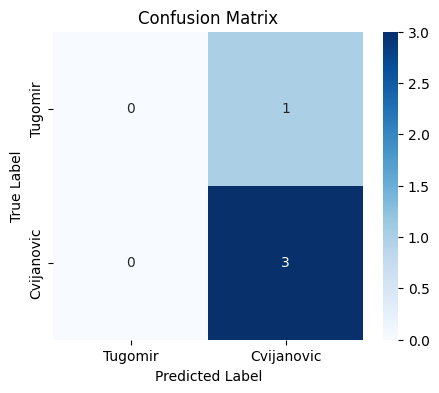

In [234]:

# Plot Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="Blues", fmt="d",
            xticklabels=["Tugomir","Cvijanovic"], yticklabels=["Tugomir","Cvijanovic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Classification report

In [235]:
# Print Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.75      1.00      0.86         3

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4



/home/kovelja/Desktop/raf_master/nlp/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kovelja/Desktop/raf_master/nlp/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kovelja/Desktop/raf_master/nlp/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

### Task 9:
Keyword extraction

In [248]:
keyword_doc = nlp(" ".join(sentences))

# Extract nouns
nouns = [token.text for token in keyword_doc if token.pos_ == "NOUN"]

# Join extracted nouns back into a single string
processed_text = ' '.join(nouns)

# Use TF-IDF to rank nouns
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform([processed_text])

top_k = 10

# Get the top k most important nouns
top_nouns = sorted(vectorizer.vocabulary_, key=lambda x: tfidf[0, vectorizer.vocabulary_[x]], reverse=True)[:top_k]

# Print the top k keywords
for i, noun in enumerate(top_nouns):
    print(f"{i+1}. {noun}")

1. је
2. вас
3. pozdrave
4. госп
5. треба
6. antologiju
7. grip
8. срдачно
9. gospođi
10. се


Wordcloud

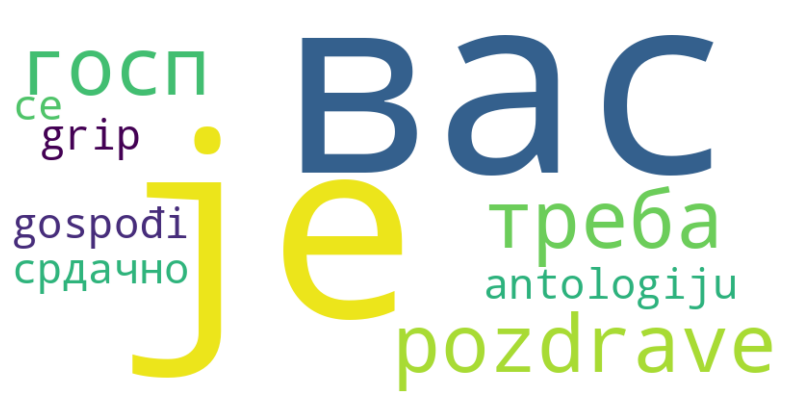

In [251]:
# WordCloud instance
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(top_nouns))

# Showing WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()